<a href="https://colab.research.google.com/github/AbdulQadir98/Rootcode_Datathon/blob/master/Image_Classification_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Mount Google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!gdown 1Z5rDIO0kLSqk23a39SaSIiujwSnJ6otz

Downloading...
From: https://drive.google.com/uc?id=1Z5rDIO0kLSqk23a39SaSIiujwSnJ6otz
To: /content/Datathon-Dataset.zip
100% 89.4M/89.4M [00:02<00:00, 44.0MB/s]


In [ ]:
!unzip *.zip

### Importing Libraries

In [ ]:
import os
import shutil
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim.lr_scheduler import MultiStepLR
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import MultiStepLR
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import img_to_array,load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from PIL import Image

### Define

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
batch_size = 32

### Creating training and test sub directories

In [ ]:
# Define paths
source_dataset_path = "/content/Datathon-Dataset"
target_dataset_path = "/content/Dataset"
train_dir = os.path.join(target_dataset_path, "train")
test_dir = os.path.join(target_dataset_path, "test")

# Create target dataset directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Get a list of class names (subdirectories in the source dataset)
class_names = os.listdir(source_dataset_path)

split_ratio = 0.8  # 80% for training, 20% for testing

# Loop through each class and process its files
for class_name in class_names:
    class_source_path = os.path.join(source_dataset_path, class_name)
    all_files = os.listdir(class_source_path)
    num_files = len(all_files)
    num_train = int(num_files * split_ratio)

    # Create subdirectories for each class within train and test directories
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    # Divide files into train and test sets
    train_files = all_files[:num_train]
    test_files = all_files[num_train:]

    # Move train files
    for train_file in train_files:
        src_path = os.path.join(class_source_path, train_file)
        dest_path = os.path.join(train_dir, class_name, train_file)
        shutil.copy(src_path, dest_path)

    # Move test files
    for test_file in test_files:
        src_path = os.path.join(class_source_path, test_file)
        dest_path = os.path.join(test_dir, class_name, test_file)
        shutil.copy(src_path, dest_path)


### Data Preprocessing and Augmentation

In [ ]:
data_path="/content/Datathon-Dataset/"

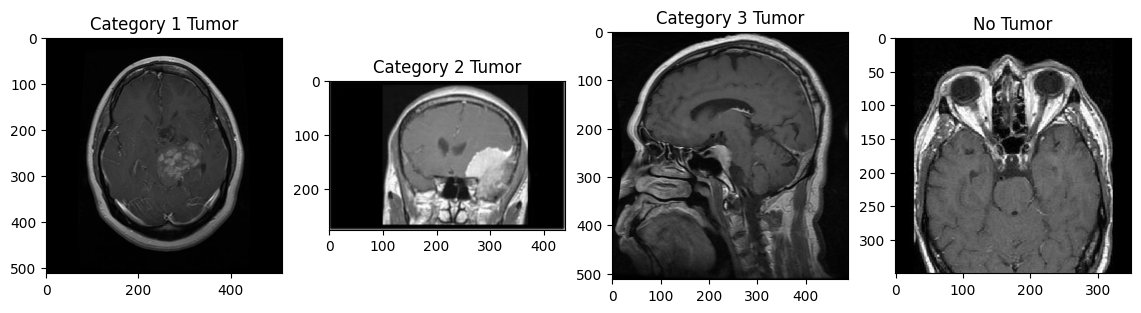

In [ ]:
labels = [
    'Category 1 Tumor',
    'Category 2 Tumor',
    'Category 3 Tumor',
    'No Tumor'
]

img=[load_img(data_path+'category1_tumor/gt_img (1).jpg'),
load_img(data_path+'category2_tumor/mt_img (1).jpg'),
load_img(data_path+'category3_tumor/pt_img (1).jpg'),
load_img(data_path+'no_tumor/nt_img (1).jpg')]
plt.figure(figsize=(14,14))
x, y = 1, 4
for i in range(4):
    plt.subplot(x, y, i+1)
    plt.imshow(img[i], cmap='gray')
    plt.title(labels[i])
plt.show()

In [ ]:
for i in range(4):
    x=img_to_array(img[i])
    print(x.shape)

(512, 512, 3)
(650, 591, 3)
(512, 512, 3)
(350, 350, 3)


Conclusion : Images are 3 channels RGB

**Noice** **Reduction**

In [ ]:
def preprocess_input(image):
    # Apply Gaussian blur to remove noise
    blurred_image = cv2.GaussianBlur(image, (5, 5), 0)
    return blurred_image

**Resampling the imbalance Class (OverSampling)**

In [ ]:
train_path="/content/Dataset/train/"
test_path="/content/Dataset/test/"

train_under_sample_path="/content/Dataset/train/no_tumor"

In [ ]:
# Oversampling

train_datagen=ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.3,
    horizontal_flip=True,
    preprocessing_function=preprocess_input
)

file_names = os.listdir(train_under_sample_path)
for i, file_name in enumerate(file_names):
    img = load_img(os.path.join(train_under_sample_path, file_name))
    img_array = img_to_array(img)
    img_array = img_array.reshape((1,) + img_array.shape)
    save_dir = os.path.join(train_under_sample_path, f"oversample_{i}")
    os.makedirs(save_dir, exist_ok=True)
    print(save_dir)
    for batch in train_datagen.flow(
        img_array,
        batch_size=1,
        save_to_dir=save_dir,
        save_prefix="aug",
        save_format="jpg",
    ):
        break

train_generator=train_datagen.flow_from_directory(
        train_path,
        target_size=(224,224),
        batch_size=batch_size,
        class_mode="categorical",
        color_mode="rgb",
        # subset='training'
)

test_datagen=ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=preprocess_input
)

test_generator=test_datagen.flow_from_directory(
        test_path,
        target_size=(224,224),
        batch_size=batch_size,
        class_mode="categorical",
        color_mode="rgb"
)

Found 2969 images belonging to 4 classes.
Found 647 images belonging to 4 classes.


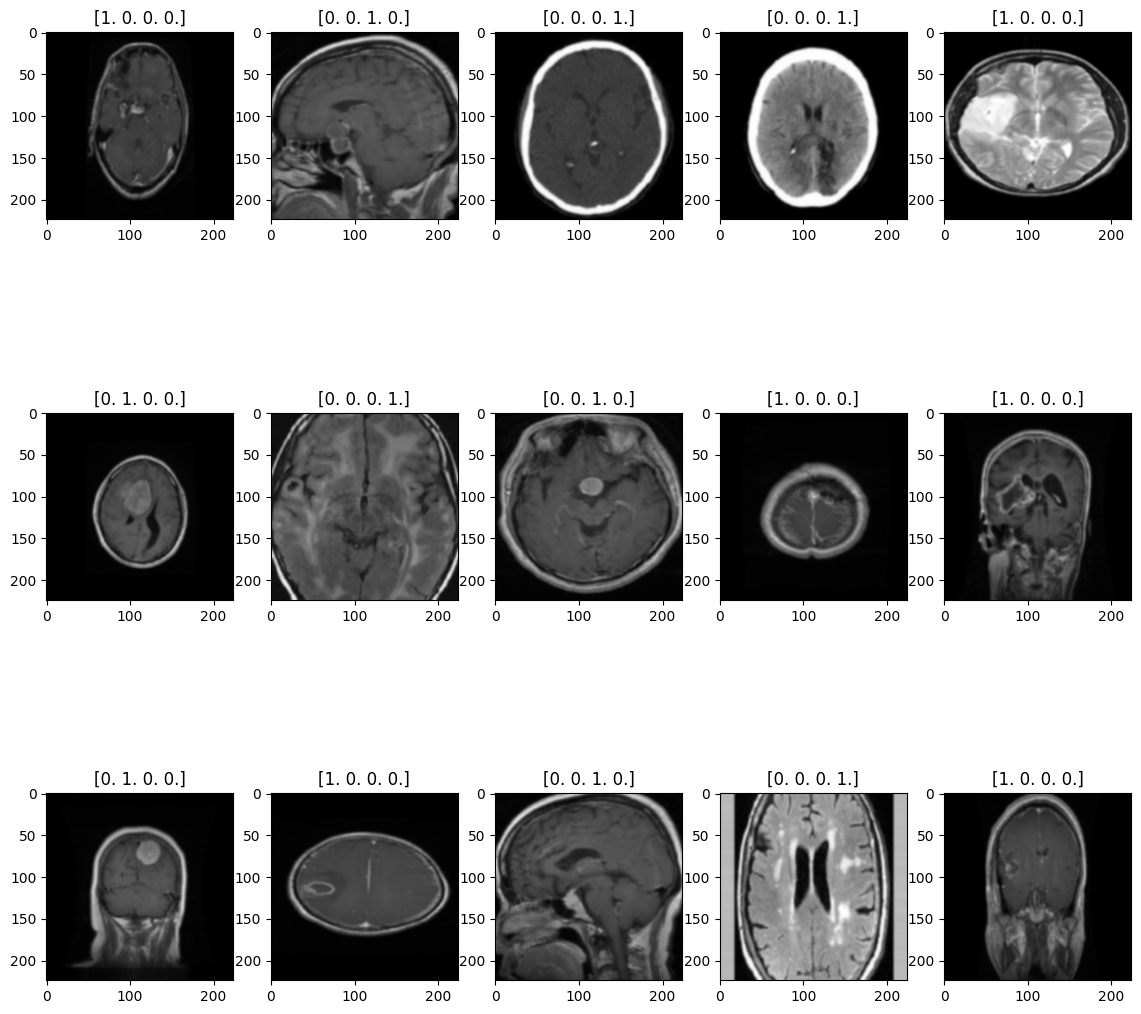

In [ ]:
batch_1_img = train_generator[0]
plt.figure(figsize=(14,14))
x, y = 3, 5
for i in range(15):
    img = batch_1_img[0][i]
    lab = batch_1_img[1][i]
    plt.subplot(x, y, i+1)
    plt.imshow(img)
    plt.title(lab)
plt.show()

**Data Augmentation**

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.Lambda(lambda img: preprocess_input(img)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.Lambda(lambda img: preprocess_input(img)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [ ]:
train_dataset = ImageFolder(train_path, train_transform)
test_dataset = ImageFolder(test_path, test_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

### Building model_1

In [ ]:
class TumorClassificationModel3(nn.Module):
    def __init__(self):
        super(TumorClassificationModel3, self).__init__()
        self.features = nn.Sequential(
            # block1
            nn.Conv2d(in_channels=3,
                      out_channels=64,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64,
                      out_channels=64,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),

            # block2
            nn.Conv2d(in_channels=64,
                      out_channels=128,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128,
                      out_channels=128,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
        )

        self.tumor_classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=524288,
                      out_features=4),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        tumor_output = self.tumor_classifier(x)
        return tumor_output

# Create an instance of the model
model2 = TumorClassificationModel3().to(device)

**Define Loss functions, Optimizers and Schedulers**

In [ ]:
torch.manual_seed(25)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr=0.0002)

# Define the scheduler
scheduler = MultiStepLR(optimizer, milestones=[30,50,75,90], gamma=0.1)

In [ ]:
# Define the directory where you want to save the model checkpoints
checkpoint_dir = 'model_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

num_epochs = 100
train_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    model2.train()  # Set the model to training mode
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()  # Zero the gradients
        outputs = model2(images)
        loss = criterion(outputs, labels)
        loss.backward()  # Backpropagation
        optimizer.step()  # Update the weights
        # scheduler.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    model2.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model2(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)
    print(f"Test Accuracy: {accuracy:.2f}%")

    # Save the model checkpoint
    checkpoint_path = os.path.join(checkpoint_dir, f'model_epoch_{epoch + 1}.pth')
    torch.save(model2.state_dict(), checkpoint_path)
    print(f"Model checkpoint saved at {checkpoint_path}")

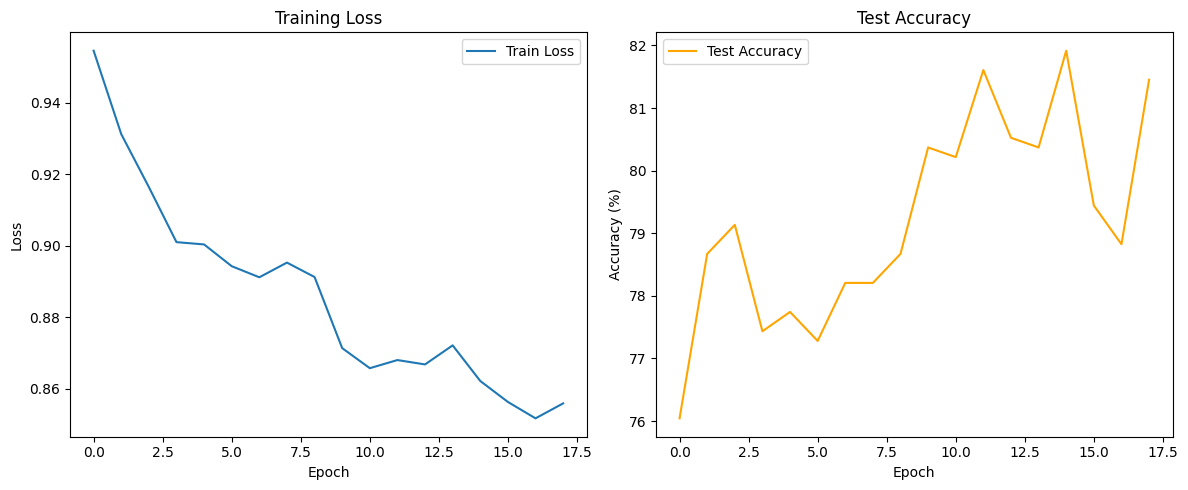

In [ ]:
# Plotting the training loss and test accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Building Model_2

In [ ]:
class TumorClassificationModel4(nn.Module):
    def __init__(self):
        super(TumorClassificationModel4, self).__init__()
        self.features = nn.Sequential(
            # block1
            nn.Conv2d(in_channels=3,
                      out_channels=64,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64,
                      out_channels=64,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),

            # block2
            nn.Conv2d(in_channels=64,
                      out_channels=128,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128,
                      out_channels=128,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),

            # block3
            nn.Conv2d(in_channels=128,
                      out_channels=256,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256,
                      out_channels=256,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256,
                      out_channels=256,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )

        self.tumor_classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=256 * (256 ** 2), out_features=512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=512, out_features=4),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        tumor_output = self.tumor_classifier(x)
        return tumor_output

# Create an instance of the model
model3 = TumorClassificationModel4().to(device)

In [ ]:
num_epochs = 100
train_losses3 = []
test_accuracies3 = []

for epoch in range(num_epochs):
    model3.train()  # Set the model to training mode
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()  # Zero the gradients
        outputs = model3(images)
        loss = criterion(outputs, labels)
        loss.backward()  # Backpropagation
        optimizer.step()  # Update the weights
        # scheduler.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    train_losses3.append(epoch_loss)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    model3.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model3(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    test_accuracies3.append(accuracy)
    print(f"Test Accuracy: {accuracy:.2f}%")

RuntimeError: ignored

### Building Model_3

In [ ]:
class TumorClassificationModel5(nn.Module):
    def __init__(self):
        super(TumorClassificationModel5, self).__init__()
        self.features = nn.Sequential(
            # block1
            nn.Conv2d(in_channels=3,
                      out_channels=64,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64,
                      out_channels=64,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),

            # block2
            nn.Conv2d(in_channels=64,
                      out_channels=128,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128,
                      out_channels=128,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),

            # block3
            nn.Conv2d(in_channels=128,
                      out_channels=256,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256,
                      out_channels=256,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256,
                      out_channels=256,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),

            # block4
            nn.Conv2d(in_channels=64,
                      out_channels=128,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128,
                      out_channels=128,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
        )

        self.tumor_classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * (image_size_after_pooling ** 2), 512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(512, 4),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        tumor_output = self.tumor_classifier(x)
        return tumor_output

# Create an instance of the model
model4 = TumorClassificationModel5().to(device)

In [ ]:
num_epochs = 100
train_losses4 = []
test_accuracies4 = []

for epoch in range(num_epochs):
    model4.train()  # Set the model to training mode
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()  # Zero the gradients
        outputs = model4(images)
        loss = criterion(outputs, labels)
        loss.backward()  # Backpropagation
        optimizer.step()  # Update the weights
        # scheduler.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    train_losses4.append(epoch_loss)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    model4.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model4(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    test_accuracies4.append(accuracy)
    print(f"Test Accuracy: {accuracy:.2f}%")

### Loading and Store Model

In [ ]:
# Load the checkpointed model
checkpoint_path = '/content/model_checkpoints/model_epoch_2.pth'
model2 = TumorClassificationModel3()  # Create an instance of your model class
model2.load_state_dict(torch.load(checkpoint_path))
model2.eval()  # Set the model to evaluation mode

TumorClassificationModel3(
  (block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (tumor_classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=524288, out_features=4, bias=True)
    (2): Softmax(dim=1)
  )
)

In [ ]:
# TO REMOVE DIRECTORIES

import shutil

directory_path = '/content/test'

shutil.rmtree(directory_path)
